# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* portfolio.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at offer_rcvd_time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import ast
import re
import math
import json
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Assess data

## Assess and clean PORTFOLIO

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# Convert duration from days into hourly values.
portfolio['duration_hours']  = portfolio['duration'] * 24

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,id,duration_hours
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,168
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,120
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,96
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,168
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,240
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,168
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,240
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,72
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,120
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,168


## Assess relationship data quality PROFILE - TRANSCRIPT

In [6]:
# portfolio.to_excel('../misc/portfolio.xlsx')
# profile.to_excel('../misc/profile.xlsx')
# transcript.to_excel('../misc/transcript.xlsx')

In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [9]:
print(f"transcript - number of records: {len(transcript)}")

transcript - number of records: 306534


### Relationship Profile - Transcript

In [10]:
# Perform the inner join
merged_df = pd.merge(profile, transcript, left_on='id', right_on='person')

# Select the required columns
result_df = merged_df[['id', 'gender', 'age', 'became_member_on', 'income', 'event', 'value', 'time']]

result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                306534 non-null  object 
 1   gender            272762 non-null  object 
 2   age               306534 non-null  int64  
 3   became_member_on  306534 non-null  int64  
 4   income            272762 non-null  float64
 5   event             306534 non-null  object 
 6   value             306534 non-null  object 
 7   time              306534 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 18.7+ MB


In [11]:
print(f"transcript inner join profile - number of records: {len(result_df)}")

transcript inner join profile - number of records: 306534


*As number of records of transcript is equal to number of records transcript inner join profile (306534) there are no records in transcript having no person in profile.*

# Preprocess Data

## Transcript


### Split up value column containing data dictionary data
As table excerpt above shows, the value column contains one or two key value pairs of form key: value, which will into separate columns

In [12]:
def split_dict_into_cols(df, col):
    ''' 
    For an entire Pandas dataframe normalize the dictionary value pairs from
    column col into individual columns named by key value.
    Correct misspelled keys for "offer_id"
    
    Arguments:
    df - Pandas dataframe
    col - Column name containing dictionary values as strings
    
    Returns:
    df_result - Dataframe with multivalue column normalized into separate columns
    df_conversion_errors - Dataframe with rows that failed to convert
    '''   

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():

        dictval = row[col]
        for key, value in dictval.items():
            # Correct misspelled keys for "offer_id"
            if key == 'offer id':
                key = 'offer_id'
            # print(f"Key: {key}, Value: {value}")
            #df.loc[index, key] = value
            df.loc[index, (key)] = value
      
    return df 

transcript_norm = split_dict_into_cols(transcript, 'value')

transcript_norm.tail(8)

,person,event,value,time,offer_id,amount,reward
306526,24f56b5e1849462093931b164eb803b5,transaction,{'amount': 22.64},714,NaN,22.64,NaN
306527,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0
306528,5ca2620962114246ab218fc648eb3934,transaction,{'amount': 2.2},714,NaN,2.20,NaN
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,NaN,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,NaN,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,NaN,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,NaN,3.53,NaN
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714,NaN,4.05,NaN


## Assess relationship data quality PORTFOLIO - TRANSCRIPT

In [13]:
print(f"Number of records in transcript_norm having offer_id populated before join with portfolio: {len(transcript_norm[(transcript_norm['offer_id'].notna())])}")
# Perform the left outer join (assure that all transript_norm records are kept)
transcript_norm = pd.merge(transcript_norm, portfolio, left_on='offer_id', right_on='id', how='left')
print(f"Number of records in transcript_norm having offer_id populated after join with portfolio: {len(transcript_norm[(transcript_norm['offer_id'].notna())])}")

Number of records in transcript_norm having offer_id populated before join with portfolio: 167581
Number of records in transcript_norm having offer_id populated after join with portfolio: 167581


*Result: As the above resulting number of records are equal, all offer_ids included in transcript have a proper record in portfolio; no dangling tuples.*

In [14]:
# xx
transcript_norm.tail(1)

,person,event,value,time,offer_id,amount,reward_x,reward_y,channels,difficulty,duration,offer_type,id,duration_hours
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714,NaN,4.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Check if there are inconsistencies related to redundant columns "reward_x", "reward_y":
print(f'Number of inconsistent rows for "reward_x", "reward_y": {len(transcript_norm[(transcript_norm['event']=='offer completed') & (transcript_norm['reward_x'] != transcript_norm['reward_y'])])}')

Number of inconsistent rows for "reward_x", "reward_y": 0


*Result: No inconsistencies regarding reward columns between transcript and portfolio regarding reward data.*

In [16]:
# xx
transcript_norm.head(5)

,person,event,value,time,offer_id,amount,reward_x,reward_y,channels,difficulty,duration,offer_type,id,duration_hours
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,168.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,5.0,"[web, email]",20.0,10.0,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,240.0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2.0,"[web, email, mobile]",10.0,7.0,discount,2906b810c7d4411798c6938adc9daaa5,168.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,fafdcd668e3743c1bb461111dcafc2a4,240.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,120.0


In [17]:
# Housekeeping for transcript_norm: 
# As there are no inconsistent rows, rename drop column "reward_x". Drop redundand columns "id" (containing "offer_id"), "value". Rename column "reward_y" to "reward"
transcript_norm.drop(['reward_x', 'id', 'value'], axis=1, inplace=True)
transcript_norm.rename(columns={'reward_y': 'offer_reward', 'channels': 'offer_channels', 'duration': 'offer_duration', 'difficulty': 'offer_difficulty', 'reward': 'offer_reward'}, inplace=True)

In [18]:
# Transform offer_duration from days to hours
# xx transcript_norm['offer_duration'] = transcript_norm['offer_duration'] * 24

In [19]:
# xx
transcript_norm.tail(1)

,person,event,time,offer_id,amount,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type,duration_hours
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,714,NaN,4.05,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# xx
transcript_norm[transcript_norm['person'] == "2eeac8d8feae4a8cad5a6af0499a211d"]

,person,event,time,offer_id,amount,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type,duration_hours
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,0.0,"[web, email, mobile]",0.0,4.0,informational,96.0
53182,2eeac8d8feae4a8cad5a6af0499a211d,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,"[web, email, mobile, social]",7.0,7.0,discount,168.0
65844,2eeac8d8feae4a8cad5a6af0499a211d,offer viewed,168,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,"[web, email, mobile, social]",7.0,7.0,discount,168.0
85293,2eeac8d8feae4a8cad5a6af0499a211d,transaction,216,NaN,2.32,NaN,NaN,NaN,NaN,NaN,NaN
110835,2eeac8d8feae4a8cad5a6af0499a211d,offer received,336,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,240.0
130152,2eeac8d8feae4a8cad5a6af0499a211d,offer viewed,348,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,240.0
141567,2eeac8d8feae4a8cad5a6af0499a211d,transaction,378,NaN,5.29,NaN,NaN,NaN,NaN,NaN,NaN
187136,2eeac8d8feae4a8cad5a6af0499a211d,transaction,456,NaN,7.14,NaN,NaN,NaN,NaN,NaN,NaN
187137,2eeac8d8feae4a8cad5a6af0499a211d,offer completed,456,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount,240.0
243231,2eeac8d8feae4a8cad5a6af0499a211d,transaction,570,NaN,0.87,NaN,NaN,NaN,NaN,NaN,NaN


## Offer Aggregation Dataframe (offer_agg)
Data is subset of transcript dataframe limited to "offer received" records of offer type "bogo", "discounts"<br>
*person* (person id from transcipt dataframe)<br>
*offer_id* (offer id from transcipt dataframe based on "offer received" records)<br>
*offer_rcvd_time* (time vale in hours from transcript dataframe based on "offer received" event for offer type "bogo", "discounts")<br>
*offer_type* (offer type from portfolio dataframe)<br>
*offer_channels* (used communication chnannels)
*offer_duration* (offer duration in hours from portfolio dataframe)<br>
*offer_difficulty* (offer difficulty from portfolio dataframe)<br>
*offer_reward* (offer reward from portfolio dataframe)<br>
*of_viewed_time* (from transcript dataframe: elapsed time in hours between "offer viewed" event and "offer received" event)<br>
*of_cmpl_time_el* (from transcript dataframe: elapsed time in hours between "offer completed" event and "offer received" event)<br>
*of_trx_amount_el* (from transcript dataframe: amount value of "transaction" event at time of "offer completed" event; if several offers are completed, split up according to reward)<br>

In [21]:
# Focus just on "offer_type" "bogo" or "discount" and all "offer received" events
offer_agg = transcript_norm.loc[(transcript_norm['event'] == 'offer received') & (transcript_norm['offer_type'].isin(['bogo', 'discount']))].copy()
# Drop column "event" as only events "offer received" are contained
offer_agg.drop(['event'], axis=1, inplace=True)

# Rename column time into offer_rcvd_time
offer_agg.rename(columns={'time': 'offer_rcvd_time'}, inplace=True)

In [22]:
offer_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61042 entries, 0 to 257885
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   person            61042 non-null  object 
 1   offer_rcvd_time   61042 non-null  int64  
 2   offer_id          61042 non-null  object 
 3   amount            0 non-null      float64
 4   offer_reward      61042 non-null  float64
 5   offer_channels    61042 non-null  object 
 6   offer_difficulty  61042 non-null  float64
 7   offer_duration    61042 non-null  float64
 8   offer_type        61042 non-null  object 
 9   duration_hours    61042 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 5.1+ MB


In [23]:
# Reorder columns
offer_agg = offer_agg[['person', 'offer_rcvd_time', 'offer_id', 'offer_type', 'offer_channels', 'offer_duration', 'offer_difficulty', 'offer_reward']]

In [24]:
offer_agg.head(5)

,person,offer_rcvd_time,offer_id,offer_type,offer_channels,offer_duration,offer_difficulty,offer_reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,"[web, email, mobile]",7.0,5.0,5.0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"[web, email]",10.0,20.0,5.0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,discount,"[web, email, mobile]",7.0,10.0,2.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,discount,"[web, email, mobile, social]",10.0,10.0,2.0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,"[web, email, mobile, social]",5.0,10.0,10.0


#### XX DEFINE TEST SET

In [25]:
# XX Limit data to a few persons
person_test_set = ['78afa995795e4d85b5d9ceeca43f5fef', '2eeac8d8feae4a8cad5a6af0499a211d', 'a03223e636434f42ac4c3df47e8bac43', 'e2127556f4f64592b11af22de27a7932', 'ffff82501cea40309d5fdd7edcca4a07']
# person_test_set = ['2eeac8d8feae4a8cad5a6af0499a211d']
# person_test_set = ['e2127556f4f64592b11af22de27a7932'] # d
# person_test_set = ['ffff82501cea40309d5fdd7edcca4a07'] # e
offer_agg = offer_agg[(offer_agg['person'].isin(person_test_set))]
# offer_agg

### Create and populate offer_agg columns to aggregate all relevant values for offers into single rows
* of_trx_amount, stored to "offer completed" record: Transaction amount at time of offer completion related to offer 
* of_trx_time, stored to "offer completed" record: Relative time between offer received and offer completed event; if offer is not completed, NaN

In [26]:
transcript_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            306534 non-null  object 
 1   event             306534 non-null  object 
 2   time              306534 non-null  int64  
 3   offer_id          167581 non-null  object 
 4   amount            138953 non-null  float64
 5   offer_reward      167581 non-null  float64
 6   offer_channels    167581 non-null  object 
 7   offer_difficulty  167581 non-null  float64
 8   offer_duration    167581 non-null  float64
 9   offer_type        167581 non-null  object 
 10  duration_hours    167581 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 25.7+ MB


In [27]:
# Check if same offers are received several times by same person
# Assuming transcript_norm is your DataFrame
# Filter the DataFrame for rows where event is 'offer_received'
filtered_df = transcript_norm[transcript_norm['event'] == 'offer received']

# Group by 'person' and 'offer_id' and count the occurrences
grouped_df = filtered_df.groupby(['person', 'offer_id']).size().reset_index(name='same_of_count')

# Filter groups having count > 1 => same offer received several times by same person
result_df = grouped_df[grouped_df['same_of_count'] > 1]


In [28]:
max_value = result_df['same_of_count'].max()
max_rows = result_df[result_df['same_of_count'] == max_value]
max_rows

,person,offer_id,same_of_count
8458,23d67a23296a485781e69c109a10a1cf,5a8bc65990b245e5a138643cd4eb9837,5
11230,2ea50de315514ccaa5079db4c1ecbc0b,fafdcd668e3743c1bb461111dcafc2a4,5
16737,43a50d7e5c8547a9aa1ec31291b9fc30,0b1e1539f2cc45b7b9fa7c272da2e1d7,5
26995,6d2db3aad94648259e539920fc2cf2a6,f19421c1d4aa40978ebb69ca19b0e20d,5
59098,eece6a9a7bdd4ea1b0f812f34fc619d6,5a8bc65990b245e5a138643cd4eb9837,5


*Result: The same offer is received up to five times by the same person. Hence the pre-processing needs to take this into account.*

In [29]:
# Get list of unique persons
persons_unique = offer_agg['person'].drop_duplicates()

*As analysis revealed, there are some transactions in the transcript data, where during one purchase event more than one offer is completed, e. g. person e2127556f4f64592b11af22de27a7932, index 225060 - 225062*. In these cases, the transaction value is split up between the offers involved according to the reward ratio of of all offers beeing completed. <br>
<img src="multiple offers per trx.png"/>

In [30]:
# xx
transcript_norm[transcript_norm['event'] =='transaction']

,person,event,time,offer_id,amount,offer_reward,offer_channels,offer_difficulty,offer_duration,offer_type,duration_hours
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,NaN,0.83,NaN,NaN,NaN,NaN,NaN,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,34.56,NaN,NaN,NaN,NaN,NaN,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,13.23,NaN,NaN,NaN,NaN,NaN,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,NaN,19.51,NaN,NaN,NaN,NaN,NaN,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,NaN,18.97,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
def update_offer_agg(offer_agg, person, offer_time_completion, transcript_norm_pers_time, amount_of_compl, sum_rewards):
    ''' 
    Update the offer_agg dataframe by aggregation all the transaction history (transcript) of an offer 
    into one single row
    
    INPUT
    person - string: current person
    offer_time_completion - integer: time of "offer completed" record
    transcript_norm_pers_time - dataframe: containing detailes of all offer_id records completed at given point in time
    amount_of_compl - float: Sum of all transactions done at time of offer completion
    sum_rewards - float: Sum of all rewards of the offer_ids
    
    OUTPUT
    (offer_agg - dataframe: All offer information aggregated into original offer received transcript files)
    '''   

    # Get additonal portfolio data based by inner joining transcript_norm_pers_time and portfolio 
    transcript_norm_pers_time = pd.merge(transcript_norm_pers_time[['person', 'event', 'time', 'offer_id', 'amount']], portfolio[['reward','channels', 'difficulty', 'duration_hours', 'offer_type', 'id']], left_on='offer_id', right_on='id')
    
    #### Grenzfall zu lösen: d
    total_reward = transcript_norm_pers_time['reward'].sum() 
    transcript_norm_pers_time['amount_share'] = round((transcript_norm_pers_time['reward'] / total_reward) * amount_of_compl, 2)
    

    # print(f"person: {person}, offer_time_completion {offer_time_completion}, amount_of_compl {amount_of_compl}, sum_rewards {sum_rewards}, \n{transcript_norm_pers_time[['person', 'event', 'time', 'duration_hours', 'offer_id', 'reward', 'amount_share']]}\n =====================")
    
    # Based on person, offer_id, duration_hours find offer_agg record (which is based on offer received records)
    # print(f'type(transcript_norm_pers_time) {type(transcript_norm_pers_time)}')
    
    for index, offer_completed in transcript_norm_pers_time.iterrows():
        # Calculate earliest offer received time to get the limit of the timeframe for idenfication of offer received record
        # print(f'type(offer_completed) {type(offer_completed)}')
        earliest_offer_rcvd = offer_completed['time'] - offer_completed['duration_hours']
        # print(f'earliest_offer_rcvd {earliest_offer_rcvd}')
        # Update offer_agg row of "offer received" record
        filter = (offer_agg['person'] == person) & (offer_agg['offer_id'] == offer_completed['offer_id']) & ((offer_agg['offer_rcvd_time'] >= earliest_offer_rcvd) & (offer_agg['offer_rcvd_time'] <= offer_completed['time']))
        # print(f"len(offer_agg) {len(offer_agg.loc[filter])}")
        # print(f"offer_agg {offer_agg.loc[filter]}")
        # Choose the timely closest record of offer received records to update the offer_agg values
        offer_agg_filtered = offer_agg.loc[filter]
        offer_agg_filtered = offer_agg_filtered.sort_values(by='offer_rcvd_time', ascending=False)
        closest_offer_rcvd_time = offer_agg_filtered['offer_rcvd_time']
        # print(f"type closest_offer_rcvd_time {closest_offer_rcvd_time.iloc[0]}")
        # print(f"closest_offer_rcvd_time {closest_offer_rcvd_time.iloc[0]}")
        # Update the filter with the closest (exact) offer_rcvd_time
        filter = (offer_agg['person'] == person) & (offer_agg['offer_id'] == offer_completed['offer_id']) & (offer_agg['offer_rcvd_time'] == closest_offer_rcvd_time.iloc[0])
        # Finally, update the offer_agg values
        # If several offers are completed at the same time the transaction amount is split according to the reward share of the involved offers
        offer_agg.loc[filter, 'offer_trx_amount'] = offer_completed['amount_share']
        
        offer_agg.loc[filter, 'offer_cmpl_time'] = offer_time_completion
    return   


In [32]:
# Process the 'event chain' person by person and "move" the transaction amount to the offer_completed record while splitting it up relative to reward ratio
for person in persons_unique:
    # Get all offer completed records by current person in order to get their offer_rcvd_time value
    transcript_norm_pers = transcript_norm[((transcript_norm['person'] == person) & (transcript_norm['event'] == 'offer completed'))]
    # print(f"transcript_norm_pers {person}:\n {transcript_norm_pers[['person', 'event', 'time', 'offer_id']]}")
    # Make point in time unique (in case of several offers completed at same time) 
    time_list_unique = transcript_norm_pers['time'].unique()
    # print(f"time_list_unique {time_list_unique}")    
    for time in time_list_unique:
        # Get all offers completed records being recorded at time of completion of current offer.
        transcript_norm_pers_time = transcript_norm_pers[(transcript_norm_pers['time'] == time) & (transcript_norm_pers['event'] == 'offer completed')]
        # print(f"*** transcript_norm_pers_time:\n {transcript_norm_pers_time[['person', 'event', 'time', 'offer_id', 'amount', 'offer_reward']]}")
        for offer_id in transcript_norm_pers_time['offer_id']:
            # Calculate the sum of all rewards of offers at that point in time:
            # print(f'time {time}')
            sum_rewards  = transcript_norm_pers_time[transcript_norm_pers_time['time'] == time]['offer_reward'].values.sum()            
            # print(f'sum_rewards {sum_rewards}')
            # Use each offer_rcvd_time value to get the previous transaction record and amount
            # As some offer_rcvd_times multiple offers are completed at the same offer_rcvd_time, split the transaction value according to the reward ratio of all completed offers at offer_rcvd_time *offer_rcvd_time*
            amount_of_compl = transcript_norm[((transcript_norm['person'] == person) & (transcript_norm['event'] == 'transaction') & (transcript_norm['time'] == time) )]['amount'].values.sum() 
            # print(amount_of_compl)

        # Having identified all offers completed records, the sum of transaction amounts and their sum of rewards, the offer_agg needs to be updated
        update_offer_agg(offer_agg, person, time, transcript_norm_pers_time, amount_of_compl, sum_rewards)   
        
        # offer_limit_time = offer_rcvd_time
        # transcript_norm_off = transcript_norm[(transcript_norm['person']==person) & (transcript_norm['time']>=offer_rcvd_time) & (transcript_norm['time']<=(offer_rcvd_time + offer_agg_per[offer_rcvd_time]) 


In [33]:
# Create and populate offer_view_time column in offer_agg
for index, offer in offer_agg.iterrows():
    offer_data = offer  # Access the row data
    
    if not pd.isna(offer_data['offer_cmpl_time']):
        offer_view_time_list = transcript_norm[
            (transcript_norm['person'] == offer_data['person']) & 
            (transcript_norm['offer_id'] == offer_data['offer_id']) & 
            (transcript_norm['event'] == 'offer viewed') & 
            (transcript_norm['time'] >= offer_data['offer_rcvd_time']) & 
            (transcript_norm['time'] <= offer_data['offer_cmpl_time'])
        ]['time'].values
    else: 
        # if offer is not completed the offer_cmpl_time cannot be used as upper limit for data selection above;
        # instead offer_rcvd_time + offer_duration must be used
        offer_view_time_list = transcript_norm[
            (transcript_norm['person'] == offer_data['person']) & 
            (transcript_norm['offer_id'] == offer_data['offer_id']) & 
            (transcript_norm['event'] == 'offer viewed') & 
            (transcript_norm['time'] >= offer_data['offer_rcvd_time']) & 
            (transcript_norm['time'] <= (offer_data['offer_rcvd_time'] + offer_data['offer_duration']))
        ]['time'].values
    
    # Extract the scalar value if the list is not empty
    offer_view_time = offer_view_time_list[0] if len(offer_view_time_list) > 0 else None
    
    # Update the offer_view_time column in offer_agg
    offer_agg.at[index, 'offer_view_time'] = offer_view_time

*As analysis of events revealed, there are "offer completed" records without corresponding "offer viewed" records after "offer received" records in the transcript. Hence the resulting NaN values offer_view_time columns are okay and can be explained by this cirumstance.* <br>
<img src="offer completed wo offer viewed.png"/>

In [34]:
# Calculate the elapsed time for offer view and offer completion relative to offer_received
offer_agg['offer_view_time_el'] = offer_agg['offer_view_time'] - offer_agg['offer_rcvd_time']
offer_agg['offer_cmpl_time_el'] = offer_agg['offer_cmpl_time'] - offer_agg['offer_rcvd_time']

## PROFILE - OFFER_AGG Relationship

In [35]:
offer_agg = pd.merge(profile, offer_agg, left_on='id', right_on='person')

In [36]:
# Drop redundant column id
offer_agg.drop(columns=['id'], inplace=True)

In [37]:
def split_strlist_into_cols(df, col):
    ''' 
    For an entire Pandas dataframe split up list of values into one-hot-encoded separated columns
    with common column name prefix <col>_
    
    INPUT
    df - Pandas dataframe 
    col - Column name within dataframe
    
    OUTPUT
    df_result - Dataframe with multivalue column normalized into separate columns
    '''   
    # One-hot encode the col column
    encoded_df = df[col].apply(lambda x: pd.Series(1, index=x)).fillna(0).astype(int)
    # Add prefix to the new columns
    encoded_df = encoded_df.add_prefix(col+'_')
    
    # Replace old column by new one-hot-encoded columns
    df_result = df.drop(col, axis=1).join(encoded_df)
    return df_result


def one_hot_encode(df, col):
    ''' 
    For an entire Pandas dataframe one-hot-encode a column with singular values
    into columns with common column name prefix <col>_
    
    INPUT
    df - Pandas dataframe 
    col - Column name within dataframe
    
    OUTPUT
    df_result - Dataframe with nominal value column normalized into separate columns (one-hot-encoded)
    '''   

    # One-hot encode the col column
    encoded_df = pd.get_dummies(df[col], prefix=col).astype(int)
    
    # Replace old column by new one-hot-encoded columns
    df_result = df.drop(col, axis=1).join(encoded_df)
    return df_result


# Encode offer_agg data

In [38]:
# One hot enccode
offer_agg = split_strlist_into_cols(offer_agg, 'offer_channels')
offer_agg = one_hot_encode(offer_agg, 'offer_type')
offer_agg = one_hot_encode(offer_agg, 'gender')

In [39]:
# Reorder columns
offer_agg = offer_agg[['person', 'gender_M', 'gender_F', 'age', 'became_member_on', 'income',
       'offer_rcvd_time', 'offer_view_time', 'offer_view_time_el', 'offer_cmpl_time', 
       'offer_cmpl_time_el', 'offer_id', 'offer_duration', 'offer_difficulty',
       'offer_reward', 'offer_channels_web', 'offer_channels_email', 'offer_channels_mobile',
       'offer_channels_social', 'offer_type_bogo', 'offer_type_discount', 'offer_trx_amount']]

In [40]:
offer_agg.columns

Index(['person', 'gender_M', 'gender_F', 'age', 'became_member_on', 'income',
       'offer_rcvd_time', 'offer_view_time', 'offer_view_time_el',
       'offer_cmpl_time', 'offer_cmpl_time_el', 'offer_id', 'offer_duration',
       'offer_difficulty', 'offer_reward', 'offer_channels_web',
       'offer_channels_email', 'offer_channels_mobile',
       'offer_channels_social', 'offer_type_bogo', 'offer_type_discount',
       'offer_trx_amount'],
      dtype='object')

In [41]:
offer_agg.to_excel(f'../misc/offer_agg-{datetime.datetime.now().strftime("%d%m%y-%H%M%S")}.xlsx')       

In [42]:
offer_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   person                 17 non-null     object 
 1   gender_M               17 non-null     int32  
 2   gender_F               17 non-null     int32  
 3   age                    17 non-null     int64  
 4   became_member_on       17 non-null     int64  
 5   income                 14 non-null     float64
 6   offer_rcvd_time        17 non-null     int64  
 7   offer_view_time        11 non-null     float64
 8   offer_view_time_el     11 non-null     float64
 9   offer_cmpl_time        12 non-null     float64
 10  offer_cmpl_time_el     12 non-null     float64
 11  offer_id               17 non-null     object 
 12  offer_duration         17 non-null     float64
 13  offer_difficulty       17 non-null     float64
 14  offer_reward           17 non-null     float64
 15  offer_ch

 # Exploratory Data Analysis

In [50]:
# Group dataframe offer_agg by 'offer_id' and aggregate the required columns
result = offer_agg.groupby('offer_id').agg({
    'offer_rcvd_time': 'count',
    'offer_view_time': 'count',
    'offer_cmpl_time': 'count',
    'offer_trx_amount': 'sum'
}).reset_index()

print(result.columns)

# Rename columns to match the desired names
result.rename(columns={
    'offer_rcvd_time': 'count_offer_rcvd',
    'offer_view_time': 'count_offer_view',
    'offer_cmpl_time': 'count_offer_cmpl'
}, inplace=True)

print(result.columns)

result['trx_amount_per_offer_rcvd'] = result['offer_trx_amount'] / result['count_offer_rcvd']

Index(['offer_id', 'offer_rcvd_time', 'offer_view_time', 'offer_cmpl_time',
       'offer_trx_amount'],
      dtype='object')
Index(['offer_id', 'count_offer_rcvd', 'count_offer_view', 'count_offer_cmpl',
       'offer_trx_amount'],
      dtype='object')


In [51]:
result

,offer_id,count_offer_rcvd,count_offer_view,count_offer_cmpl,offer_trx_amount,trx_amount_per_offer_rcvd
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,2,1,22.88,5.720000
1,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,0.00,0.000000
2,2906b810c7d4411798c6938adc9daaa5,4,2,3,47.35,11.837500
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,3,2,3,40.84,13.613333
4,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,14.48,14.480000
5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,1,7.24,7.240000
6,fafdcd668e3743c1bb461111dcafc2a4,3,3,3,28.46,9.486667


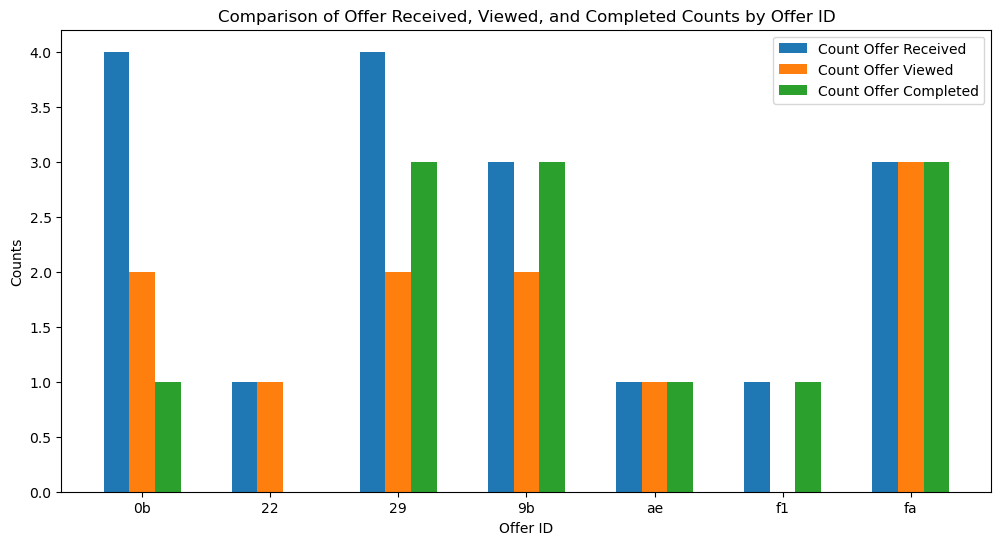

In [ ]:
# Create a bar graph to compare count_offer_rcvd_time, count_offer_view_time, count_offer_cmpl_time for each offer_id

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions and width for the bars
positions = range(len(result))
width = 0.2

# Plot the bars
plt.bar(positions, result['count_offer_rcvd'], width=width, label='Count Offer Received')
plt.bar([p + width for p in positions], result['count_offer_view'], width=width, label='Count Offer Viewed')
plt.bar([p + width * 2 for p in positions], result['count_offer_cmpl'], width=width, label='Count Offer Completed')

# Set the x-axis labels and positions
plt.xlabel('Offer ID')
plt.ylabel('Counts')
plt.title('Comparison of Offer Received, Viewed, and Completed Counts by Offer ID')
plt.xticks([p + width for p in positions], result['offer_id'].str[:2])

# Add legend
plt.legend()

# Show the plot
plt.show()


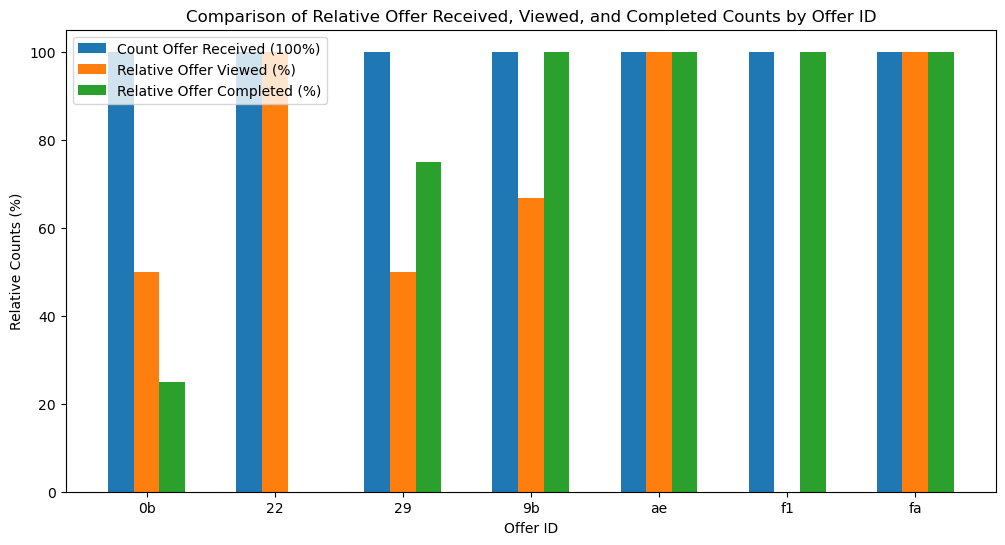

In [56]:
# Calculate relative values where count_offer_rcvd is 100%
result['relative_offer_view'] = (result['count_offer_view'] / result['count_offer_rcvd']) * 100
result['relative_offer_cmpl'] = (result['count_offer_cmpl'] / result['count_offer_rcvd']) * 100

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions and width for the bars
positions = range(len(result))
width = 0.2

# Plot the bars
plt.bar(positions, [100] * len(result), width=width, label='Count Offer Received (100%)')
plt.bar([p + width for p in positions], result['relative_offer_view'], width=width, label='Relative Offer Viewed (%)')
plt.bar([p + width * 2 for p in positions], result['relative_offer_cmpl'], width=width, label='Relative Offer Completed (%)')

# Set the x-axis labels and positions
plt.xlabel('Offer ID')
plt.ylabel('Relative Counts (%)')
plt.title('Comparison of Relative Offer Received, Viewed, and Completed Counts by Offer ID')
plt.xticks([p + width for p in positions], result['offer_id'].str[:2])

# Add legend
plt.legend()

# Show the plot
plt.show()